In [76]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats
#making healpy maps
import h5py as h5
import healpy as hp
import os

import imp
imp.reload(setup)

<module 'setup' from '/home/jthwaites/FRB/setup.py'>

In [57]:
import setup
import chime_localizations as loc

In [93]:
mpl.rcParams['font.size'] = 20
ana=cy.CONF['ana']

seed=0
new_nside=512

In [94]:
frbs=setup.load_frbs(spatial_priors=True)
#spatial prior: use FRB20190416A, dec=33.3
wn=np.where(frbs['src']=='FRB20190416A')
wn=wn[0][0] #want only one of the bursts

frb_probs, msk=loc.make_healpix_map('FRB20190416A', new_nside=new_nside, max_cl=0.9997)

sum of map probabilities: 1.00000


In [95]:
src=setup.sources(84600., frbs['mjd'].values[wn], frbs['ra_deg'].values[wn], 
                  frbs['dec_deg'].values[wn])

##sp_tr used for getting llh prior, injecting events
sp_tr = cy.get_spatial_prior_trial_runner(src_tr=src, 
                        llh_priors=frb_probs, get_pixmask=True)

In [96]:
##inj signal w sp_tr
#nsig=1
sig_trial= sp_tr.get_one_trial(nsig,seed=seed, poisson=True)

##check this fix again, seems ok with utils.py line 286
sig_trial.evss[0][1]['energy']=10**(sig_trial.evss[0][1]['log10energy'])
print('ra=%.2f, dec=%.2f'%(np.degrees(sig_trial.ra[0]),np.degrees(sig_trial.dec[0])))

ra=143.26, dec=33.24


In [97]:
## scan sky, w/in 99.97% CL only - pixmask call
sstr = cy.get_sky_scan_trial_runner(ana=ana, nside=new_nside, 
            src_kw={'mjd':src['mjd'], 't_100':src['t_100'], 'sigma_t':0.}, 
            pixmask=msk)

#%time scan = sstr.get_one_scan(seed = seed, mp_cpus=15, logging=True)

##if signal trial: 
%time scan = sstr.get_one_scan_from_trial(sig_trial, seed = seed, mp_cpus=15, logging=True)

Scanning 226 locations using 15 cores:
        226/226 coordinates complete.   
CPU times: user 162 ms, sys: 1.73 s, total: 1.89 s
Wall time: 4.38 s


In [98]:
#if len(np.where(scan[1]>0.)[0])==0: max_map=2. 
#else: max_map=max(scan[1])
#hp.mollview(scan[1], coord='C',rot=180, min=0., max=max_map)

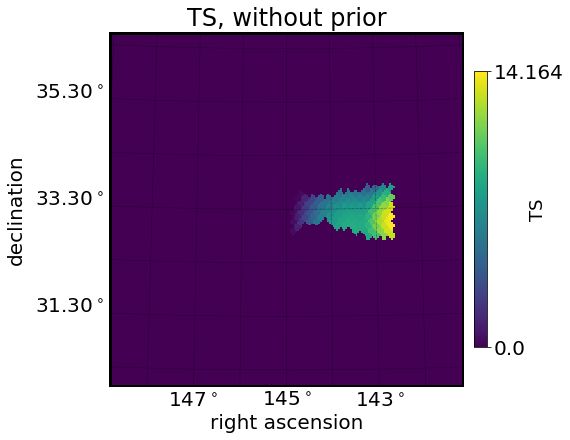

In [99]:
ts_range=[min(sp_tr.llh_prior_term[0]),max(scan[1])]
setup.plot_zoom(scan[1], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, without prior',
                reso=2., col_label=r"TS", cmap='viridis')

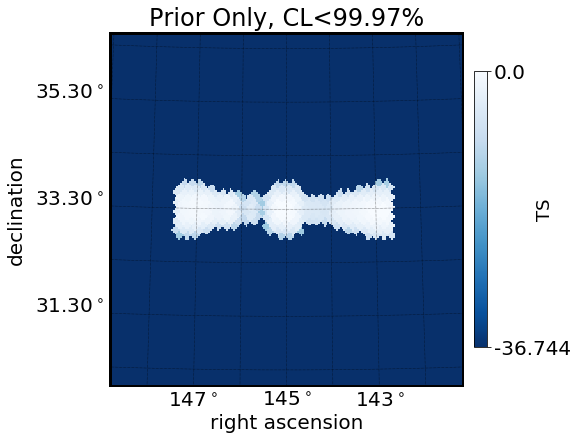

In [100]:
setup.plot_zoom(sp_tr.llh_prior_term[0], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='Prior Only, CL<99.97%', 
                reso=2., col_label=r"TS", cmap='Blues')

In [101]:
#make ts_with_prior >=0
ts_with_prior=np.zeros(len(scan[1]))
w=np.where(scan[1]>0.)[0]
for i in w:
    pixel_ts=scan[1][i] + sp_tr.llh_prior_term[0][i]
    ts_with_prior[i]=max([pixel_ts,0])
    
#ts_with_prior = scan[1] + sp_tr.llh_prior_term[0]

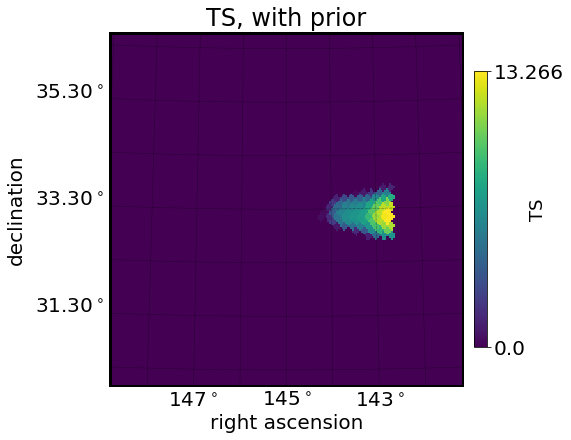

In [102]:
setup.plot_zoom(ts_with_prior, src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, with prior', 
                reso=2, col_label=r"TS", cmap='viridis')